In [ ]:
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import pandas as pd
from itertools import accumulate
import seaborn as sns
from prettytable import PrettyTable
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import statsmodels.api as sm
from statsmodels.formula.api import ols
import re
import nltk
from nltk.corpus import stopwords
import spacy
import matplotlib.pylab as plt
import matplotlib.patches as patches
from sklearn.metrics import roc_curve,auc
from scipy import interp

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def response_coding(df, feature):
  str1="class_1_"+feature
  str2="class_0_"+feature
  unique_cat_labels = df[feature].unique()
  row_col1 = []
  row_col2 = []
  row_col3 = []
  for i in range(len(unique_cat_labels)):
    total_count = df.loc[:,feature][(df[feature] == unique_cat_labels[i])].count()
    p_0 = df.loc[:, feature][((df[feature] == unique_cat_labels[i]) & (df['class_label']==0))].count()
    p_1 = df.loc[:, feature][((df[feature] == unique_cat_labels[i]) & (df['class_label']==1))].count()

    row_col1.append(unique_cat_labels[i])
    row_col2.append(p_1/total_count)
    row_col3.append(p_0/total_count)
  df_rc = pd.DataFrame(list(zip(row_col1, row_col2,row_col3)),
               columns =[feature,str1,str2])
  return df_rc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Colab Notebooks/AppliedAI/Assign23_Self_Case_Study1/Data/

/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/AppliedAI/Assign23_Self_Case_Study1/Data


In [ ]:
customers_df = pd.read_csv('olist_customers_dataset.csv')
geolocation_df = pd.read_csv('olist_geolocation_dataset.csv')
order_items_df = pd.read_csv('olist_order_items_dataset.csv')
order_payments_df = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews_df = pd.read_csv('olist_order_reviews_dataset.csv')
orders_df = pd.read_csv('olist_orders_dataset.csv')
products_df = pd.read_csv('olist_products_dataset.csv')
sellers_df = pd.read_csv('olist_sellers_dataset.csv')
product_category_name_translation_df = pd.read_csv('product_category_name_translation.csv')

In [ ]:
m1_df = pd.merge(order_items_df,products_df,on='product_id')
m2_df = pd.merge(m1_df,sellers_df,on='seller_id')
m3_df = pd.merge(m2_df,orders_df,on='order_id')
m4_df = pd.merge(m3_df,customers_df,on='customer_id')
m5_df = pd.merge(m4_df,order_reviews_df,on='order_id')
m6_df = pd.merge(m5_df,product_category_name_translation_df,on='product_category_name')
final_df = pd.merge(m6_df,order_payments_df,on='order_id')
tmp_df = final_df[['product_id','seller_id','order_id','customer_id','product_category_name']]
tmp_df.head(5)

,product_id,seller_id,order_id,customer_id,product_category_name
0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,cool_stuff
1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,130898c0987d1801452a8ed92a670612,e6eecc5a77de221464d1c4eaff0a9b64,cool_stuff
2,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,532ed5e14e24ae1f0d735b91524b98b9,4ef55bf80f711b372afebcb7c715344a,cool_stuff
3,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,6f8c31653edb8c83e1a739408b5ff750,30407a72ad8b3f4df4d15369126b20c9,cool_stuff
4,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,7d19f4ef4d04461989632411b7e588b9,91a792fef70ecd8cc69d3c7feb3d12da,cool_stuff


In [ ]:
final_df.describe()

,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value
count,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115608.000000,115608.000000,115608.000000,115608.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000
mean,1.194535,120.619850,20.056880,48.766541,785.808198,2.205373,2113.907697,30.307903,16.638477,23.113167,24515.713958,35061.537597,4.034409,1.093747,2.946233,172.387379
std,0.685926,182.653476,15.836184,10.034187,652.418619,1.717771,3781.754895,16.211108,13.473570,11.755083,27636.640968,29841.671732,1.385584,0.729849,2.781087,265.873969
min,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,1003.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,39.900000,13.080000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,11310.000000,4.000000,1.000000,1.000000,60.870000
50%,1.000000,74.900000,16.320000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13660.000000,24241.000000,5.000000,1.000000,2.000000,108.050000
75%,1.000000,134.900000,21.210000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,28605.000000,58745.000000,5.000000,1.000000,4.000000,189.480000
max,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,99980.000000,5.000000,29.000000,24.000000,13664.080000


In [ ]:
final_df = final_df.drop_duplicates(subset=['order_id','order_purchase_timestamp','product_id','customer_unique_id','review_comment_message'])
final_df.drop(['order_id','product_id','seller_id','customer_unique_id'], axis=1, inplace=True)
final_df.dropna(inplace=True)
final_df['class_label'] = np.where(final_df['review_score']> 3, 1, 0)
final_df.to_csv("merge_data.csv")

In [ ]:
df = pd.read_csv("merge_data.csv")

In [ ]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"], format='%Y-%m-%d %H:%M:%S')
df["order_delivered_carrier_date"] = pd.to_datetime(df["order_delivered_carrier_date"], format='%Y-%m-%d %H:%M:%S')
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"], format='%Y-%m-%d %H:%M:%S')
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"], format='%Y-%m-%d %H:%M:%S')
df["shipping_limit_date"] = pd.to_datetime(df["shipping_limit_date"], format='%Y-%m-%d %H:%M:%S')

df['days_diff_deivery'] = (df.order_delivered_customer_date - df.order_purchase_timestamp)/np.timedelta64(1, 'D')
df['days_diff_est_del'] = (df.order_estimated_delivery_date - df.order_delivered_customer_date)/np.timedelta64(1, 'D')
df['days_diff_shp_del'] = (df.shipping_limit_date - df.order_delivered_customer_date)/np.timedelta64(1, 'D')

In [ ]:
df['product_category_name'].fillna(value=df['product_category_name'].mode()[0], inplace=True)
df['product_name_lenght'].fillna(value=df['product_name_lenght'].mode()[0], inplace=True)
df['product_description_lenght'].fillna(value=df['product_description_lenght'].median(), inplace=True)
df['product_photos_qty'].fillna(value=df['product_photos_qty'].mode()[0], inplace=True)
df['product_weight_g'].fillna(value=df['product_weight_g'].mode()[0], inplace=True)
df['product_length_cm'].fillna(value=df['product_length_cm'].mode()[0], inplace=True)
df['product_height_cm'].fillna(value=df['product_height_cm'].mode()[0], inplace=True)
df['product_width_cm'].fillna(value=df['product_width_cm'].mode()[0], inplace=True)
df['review_comment_message'].fillna(value='noval', inplace=True)

In [ ]:
df = df[df['order_status'] != 'canceled']
df['review_flag'] = df['review_comment_message'].apply(lambda x: 1 if x != 'noval' else 0)

In [ ]:
seller_city_rc = response_coding(df,'seller_city')
seller_state_rc = response_coding(df,'seller_state')
seller_zip_code_prefix_rc = response_coding(df,'seller_zip_code_prefix')
customer_zip_code_prefix_rc = response_coding(df,'customer_zip_code_prefix')
customer_city_rc = response_coding(df,'customer_city')
customer_state_rc = response_coding(df,'customer_state')
res_tmp1_df = pd.merge(df, seller_city_rc, on="seller_city")
res_tmp2_df = pd.merge(res_tmp1_df, seller_state_rc, on="seller_state")
res_tmp3_df = pd.merge(res_tmp2_df, seller_zip_code_prefix_rc, on="seller_zip_code_prefix")
res_tmp4_df = pd.merge(res_tmp3_df, customer_zip_code_prefix_rc, on="customer_zip_code_prefix")
res_tmp5_df = pd.merge(res_tmp4_df, customer_city_rc, on="customer_city")
res_df = pd.merge(res_tmp5_df, customer_state_rc, on="customer_state")


In [ ]:
customer_zip_code_prefix_rc.set_index("customer_zip_code_prefix", drop=True, inplace=True)
customer_state_dict = customer_zip_code_prefix_rc.to_dict(orient="index")
customer_state_dict

In [ ]:
df['seller_city_rc'] = df['seller_city'].map(seller_city_dict)
df_final = pd.concat([df, df['seller_city_rc'].apply(pd.Series)], axis = 1).drop('seller_city_rc', axis = 1)
df_final

,Unnamed: 0,order_item_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,...,payment_type,payment_installments,payment_value,class_label,days_diff_deivery,days_diff_est_del,days_diff_shp_del,review_flag,class_1_seller_city,class_0_seller_city
0,2,1,2018-05-23 10:56:25,64.90,18.33,cool_stuff,58.0,598.0,4.0,650.0,...,credit_card,2,83.23,1,17.339271,2.226088,-12.318067,1,1.000000,0.000000
1,163,1,2018-04-19 14:51:50,133.05,15.81,cool_stuff,56.0,1400.0,2.0,585.0,...,credit_card,1,148.86,1,19.093935,15.291794,-13.088877,1,0.635036,0.364964
2,164,1,2018-06-20 11:59:47,1013.40,22.39,cool_stuff,43.0,712.0,2.0,5288.0,...,credit_card,5,1035.79,1,4.174282,10.342708,1.842558,1,0.635036,0.364964
3,165,3,2018-06-18 16:30:57,99.99,19.16,cool_stuff,47.0,404.0,1.0,525.0,...,credit_card,18,397.90,0,2.988935,26.345752,3.033912,1,0.817814,0.182186
4,166,4,2018-06-18 16:30:57,39.90,0.96,telefonia,53.0,538.0,1.0,200.0,...,credit_card,18,397.90,0,2.988935,26.345752,3.033912,1,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9950,115574,1,2018-07-31 10:35:17,19.80,7.40,artes_e_artesanato,53.0,529.0,2.0,325.0,...,credit_card,1,27.20,1,1.625428,5.939155,4.380324,1,0.666667,0.333333
9951,115576,1,2018-07-30 09:17:39,19.00,12.86,artes_e_artesanato,32.0,660.0,3.0,500.0,...,credit_card,1,84.63,0,3.811759,9.413773,2.801030,1,0.514286,0.485714
9952,115577,2,2018-07-30 09:17:39,39.90,12.87,artes_e_artesanato,57.0,942.0,5.0,500.0,...,credit_card,1,84.63,0,3.811759,9.413773,2.801030,1,0.514286,0.485714
9953,115579,1,2018-08-27 11:50:47,289.49,24.83,artes_e_artesanato,47.0,1002.0,3.0,1900.0,...,credit_card,5,314.32,1,3.067593,12.453877,2.947477,1,1.000000,0.000000


In [ ]:
final_df = res_df[['payment_value','price', 'freight_value','product_name_lenght','product_description_lenght', 'product_photos_qty','product_weight_g','product_length_cm', 'product_height_cm','product_width_cm','days_diff_deivery', 'days_diff_est_del', 'class_1_seller_city','class_0_seller_city','class_1_seller_state','days_diff_shp_del','class_0_seller_state','class_1_seller_zip_code_prefix','class_0_seller_zip_code_prefix','class_1_customer_zip_code_prefix','class_0_customer_zip_code_prefix','class_1_customer_city', 'class_0_customer_city','class_1_customer_state', 'class_0_customer_state']]
final_text_df = res_df[['review_comment_title','review_comment_message']]
class_label_df = res_df['class_label']

In [ ]:
final_df.to_csv("finalDF_data.csv")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_df, class_label_df, stratify=class_label_df, test_size=0.2, random_state=0)
print('Train data:', X_train.shape, y_train.shape)
print('Test data:', X_test.shape, y_test.shape)

Train data: (7964, 25) (7964,)
Test data: (1991, 25) (1991,)


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train[['payment_value','price', 'freight_value','product_name_lenght','product_description_lenght', 'product_photos_qty','product_weight_g','product_length_cm', 'product_height_cm','product_width_cm','days_diff_deivery', 'days_diff_est_del', 'class_1_seller_city','class_0_seller_city','class_1_seller_state','days_diff_shp_del','class_0_seller_state','class_1_seller_zip_code_prefix','class_0_seller_zip_code_prefix','class_1_customer_zip_code_prefix','class_0_customer_zip_code_prefix','class_1_customer_city', 'class_0_customer_city','class_1_customer_state', 'class_0_customer_state']])
X_train_scaler = scaler.transform(X_train[['payment_value','price', 'freight_value','product_name_lenght','product_description_lenght', 'product_photos_qty','product_weight_g','product_length_cm', 'product_height_cm','product_width_cm','days_diff_deivery', 'days_diff_est_del', 'class_1_seller_city','class_0_seller_city','class_1_seller_state','days_diff_shp_del','class_0_seller_state','class_1_seller_zip_code_prefix','class_0_seller_zip_code_prefix','class_1_customer_zip_code_prefix','class_0_customer_zip_code_prefix','class_1_customer_city', 'class_0_customer_city','class_1_customer_state', 'class_0_customer_state']])
X_test_scaler = scaler.transform(X_test[['payment_value','price', 'freight_value','product_name_lenght','product_description_lenght', 'product_photos_qty','product_weight_g','product_length_cm', 'product_height_cm','product_width_cm','days_diff_deivery', 'days_diff_est_del', 'class_1_seller_city','class_0_seller_city','class_1_seller_state','days_diff_shp_del','class_0_seller_state','class_1_seller_zip_code_prefix','class_0_seller_zip_code_prefix','class_1_customer_zip_code_prefix','class_0_customer_zip_code_prefix','class_1_customer_city', 'class_0_customer_city','class_1_customer_state', 'class_0_customer_state']])

In [ ]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5,shuffle=False)

Logistic Regression

In [ ]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(C=100, penalty='l2', solver ='newton-cg')

# fit the model with data
logreg.fit(X_train_scaler,y_train.values.ravel())

#
y_pred=logreg.predict(X_test_scaler)
y_train_pred=logreg.predict(X_train_scaler)

In [ ]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 484,  108],
       [  71, 1328]])

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='macro')

0.8904006925512302

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.910095429432446
Precision: 0.924791086350975
Recall: 0.9492494639027877


Train AUC

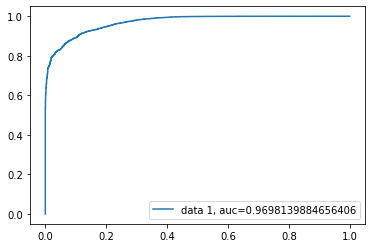

In [ ]:
from sklearn import metrics
y_pred_proba = logreg.predict_proba(X_train_scaler)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred_proba)
auc = metrics.roc_auc_score(y_train, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Test AUC

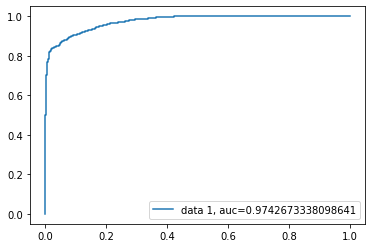

In [ ]:
from sklearn import metrics
y_pred_proba = logreg.predict_proba(X_test_scaler)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Random Forest

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score, average='macro')

# define models and parameters
model = RandomForestClassifier()

# define grid search
grid = {'max_depth': [10, 20],
'max_features': ['auto', 'sqrt'],
'min_samples_leaf': [1, 2, 4],
'min_samples_split': [2, 5, 10],
'n_estimators': [200, 400]
}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#scoring =['recall','roc_auc','f1','precision']
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=f1,error_score=0)
grid_result = grid_search.fit(final_df, class_label_df)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.892400 using {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
0.889133 (0.009459) with: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.889194 (0.009470) with: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
0.889900 (0.009557) with: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
0.889186 (0.009515) with: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
0.888546 (0.010057) with: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
0.888896 (0.009683) with: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 400}
0.888338 (0.009882) with: {'max_depth': 10, 'max_fe

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#
# Train the mode
#
forest = RandomForestClassifier(max_depth=20,max_features='sqrt',min_samples_leaf=1, min_samples_split=5, n_estimators=200)
forest.fit(X_train, y_train.values.ravel())
#
y_pred=forest.predict(X_test)

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


array([[ 493,   99],
       [  75, 1324]])

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='macro')

0.8941708008504606

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9136112506278252
Precision: 0.9323467230443975
Recall: 0.9456754824874911


Train AUC

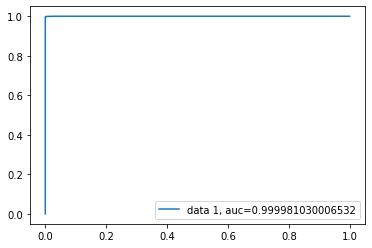

In [ ]:
from sklearn import metrics
y_pred_proba = forest.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred_proba)
auc = metrics.roc_auc_score(y_train, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Test AUC

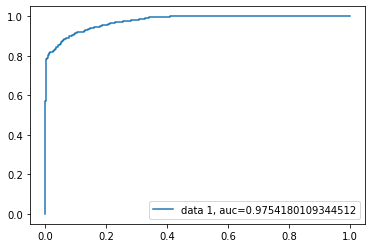

In [ ]:
y_pred_proba = forest.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:

# pickling the model
import pickle
pickle_out = open("classifier.pkl", "wb")
pickle.dump(forest, pickle_out)
pickle_out.close()

XGBoost Model

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

space={'max_depth': [3,1],'gamma': [1,9],'reg_alpha' :[40,1],'reg_lambda' :[0,1],'colsample_bytree' : [0.5,1],'min_child_weight' : [0, 1],'n_estimators': [10]}


# define models and parameters
model = XGBClassifier()

# define grid search
#grid = {'C': [0.1, 1],'gamma': [1, 0.1]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#scoring =['recall','roc_auc','f1','precision']
grid_search = GridSearchCV(estimator=model, param_grid=space, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(final_df, class_label_df)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.968870 using {'colsample_bytree': 0.5, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10, 'reg_alpha': 1, 'reg_lambda': 0}
0.966114 (0.004240) with: {'colsample_bytree': 0.5, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 10, 'reg_alpha': 40, 'reg_lambda': 0}
0.966034 (0.004249) with: {'colsample_bytree': 0.5, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 10, 'reg_alpha': 40, 'reg_lambda': 1}
0.968821 (0.004078) with: {'colsample_bytree': 0.5, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 10, 'reg_alpha': 1, 'reg_lambda': 0}
0.968738 (0.004125) with: {'colsample_bytree': 0.5, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 10, 'reg_alpha': 1, 'reg_lambda': 1}
0.966063 (0.004263) with: {'colsample_bytree': 0.5, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10, 'reg_alpha': 40, 'reg_lambda': 0}
0.966026 (0.004234) with: {'colsample_bytree': 0.5, 'gamma': 1, 'm

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(colsample_bytree=0.5, gamma=1, max_depth=3, min_child_weight=1, n_estimators=10, reg_alpha=1, reg_lambda=0)
xgb.fit(X_train,y_train.values.ravel())
y_pred=xgb.predict(X_test)

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 480,  112],
       [  83, 1316]])

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='macro')

0.8810955581383597

In [ ]:
# pickling the model
import pickle
pickle_out = open("xgbclassifier.pkl", "wb")
pickle.dump(xgb, pickle_out)
pickle_out.close()

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9020592667001507
Precision: 0.9221598877980365
Recall: 0.9399571122230165


Train AUC

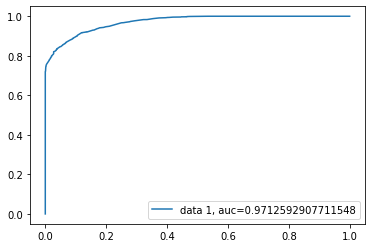

In [ ]:
from sklearn import metrics
y_pred_proba = xgb.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred_proba)
auc = metrics.roc_auc_score(y_train, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Test AUC

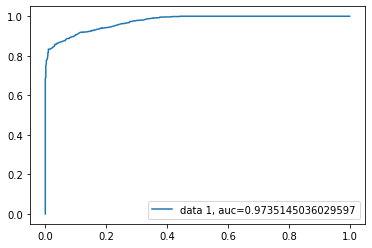

In [ ]:
y_pred_proba = xgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()